# 1. Description   

The notebook is aimed to test AutoML solutions: [TPOT](http://epistasislab.github.io/tpot/), [H2O](https://h2o.ai/platform/h2o-automl/), [Fedot](https://fedot.readthedocs.io/en/latest/) based on [Pump it Up: Data Mining the Water Table](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/) classification case.

## About dataset

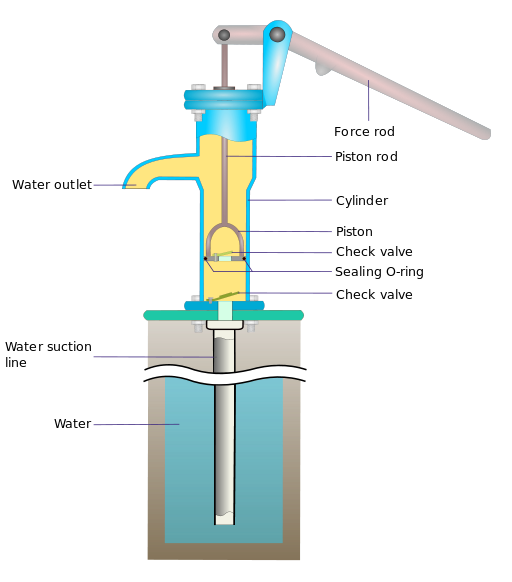

Can you predict which water pumps are faulty?    

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

### Features

Your goal is to predict the operating condition of a waterpoint for each record in the dataset. You are provided the following set of information about the waterpoints:   

* `amount_tsh` - Total static head (amount water available to waterpoint)
* `date_recorded` - The date the row was entered
* `funder` - Who funded the well
* `gps_height` - Altitude of the well
* `installer` - Organization that installed the well
* `longitude` - GPS coordinate
* `latitude` - GPS coordinate
* `wpt_name` - Name of the waterpoint if there is one
* `num_private` -
* `basin` - Geographic water basin
* `subvillage` - Geographic location
* `region` - Geographic location
* `region_code` - Geographic location (coded)
* `district_code` - Geographic location (coded)
* `lga` - Geographic location
* `ward` - Geographic location
* `population` - Population around the well
* `public_meeting` - True/False
* `recorded_by` - Group entering this row of data
* `scheme_management` - Who operates the waterpoint
* `scheme_name` - Who operates the waterpoint
* `permit` - If the waterpoint is permitted
* `construction_year` - Year the waterpoint was constructed
* `extraction_type` - The kind of extraction the waterpoint uses
* `extraction_type_group` - The kind of extraction the waterpoint uses
* `extraction_type_class` - The kind of extraction the waterpoint uses
* `management` - How the waterpoint is managed
* `management_group` - How the waterpoint is managed
* `payment` - What the water costs
* `payment_type` - What the water costs
* `water_quality` - The quality of the water
* `quality_group` - The quality of the water
* `quantity` - The quantity of water
* `quantity_group` - The quantity of water
* `source` - The source of the water
* `source_type` - The source of the water
* `source_class` - The source of the water
* `waterpoint_type` - The kind of waterpoint
* `waterpoint_type_group` - The kind of waterpoint    

The labels in this dataset are simple. There are three possible values:   

* `functional` - the waterpoint is operational and there are no repairs needed
* `functional needs repair` - the waterpoint is operational, but needs repairs
* `non functional` - the waterpoint is not operational   

Metric - `accuracy`.

# 2. Imports

In [3]:
import pandas as pd
import numpy as np

from eli5.sklearn import PermutationImportance
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from category_encoders import BinaryEncoder

from tpot import TPOTClassifier
import h2o
from h2o.automl import H2OAutoML
from fedot.api.main import Fedot
from fedot.core.repository.quality_metrics_repository import ClassificationMetricsEnum

c:\Users\parshin_sa2\Miniconda3\envs\automl-probe\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


# 3. Constants

In [3]:
SEED = 42
DATA_FOLDER = "./data/"
PREDICTION_FOLDER = "./predictions/"

# 4. Data preparation

In [ ]:
def cr_metric(ground_truth: np.ndarray, predictions: np.ndarray) -> float:
    """Accuracy metric as it is written in the challenge

    Args:
        ground_truth (np.ndarray): test data
        predictions (np.ndarray): predicted data

    Returns:
        float: metric result
    """
    cr = sum(ground_truth == predictions) / len(ground_truth)
    return cr

Data types

In [4]:
df_train_x_dtype = {"construction_year": int,
                    "population": int,
                    "district_code": int,
                    "region_code": int,
                    "num_private": int,
                    "latitude": "float32",
                    "longtitude": "float32",
                    "gps_height": int,
                    "amount_tsh": "float32",}
                    # "management_group": "category", 
                    # "region": "category",
                    # "public_meeting": "boolean",
                    # "date_recorded": str}

Read data

In [5]:
df_train_x = pd.read_csv(DATA_FOLDER + 'training_values.csv', na_values='NaN', index_col='id', dtype=df_train_x_dtype)
# Transform to UNIX format
dates = (pd.to_datetime(df_train_x['date_recorded'], format='%Y-%m-%d %H:%M:%S')
         - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df_train_x['date_recorded'] = dates

df_train_y = pd.read_csv(DATA_FOLDER + 'training_target.csv', na_values='NaN', index_col='id')

Prepare prediction labels and separate numerical and categorical columns   

In [6]:
le = LabelEncoder()

df_train_num_cols = df_train_x._get_numeric_data().columns
df_train_cat_cols = list(set(df_train_x.columns) - set(df_train_num_cols))
# y_colname = df_train_y.columns[0]
# df_train[df_train_y.columns] = df_train_y
# df_train = df_train[df_train[y_colname].notna()]

df_train_y = le.fit_transform(df_train_y)

c:\Users\parshin_sa2\Miniconda3\envs\base_py.3.10\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train-test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train_x,
    df_train_y,
    test_size=.3,
    random_state=SEED,
    stratify=df_train_y
)

Create own metric

In [8]:
cr_scorer = make_scorer(cr_metric, greater_is_better=True)

# 5. Baseline

In [13]:
n_iter = 100
# Scorer

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
           ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", BinaryEncoder(drop_invariant=True)),
        ("imputer", SimpleImputer(strategy="median")),
        ('scaler', StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, df_train_num_cols),
        ("cat", categorical_transformer, df_train_cat_cols),
    ]
)

feature_selector = VarianceThreshold(.99 * (1 - .99))
# feature_selector = PermutationImportance(LogisticRegression(penalty="l1", solver='liblinear'), scoring=cr_scorer, cv=None)

clf = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("feature_selector", feature_selector),
           ("classifier", RandomForestClassifier())]
)

param_grid = {
    'classifier__n_estimators': [20, 50, 100], # np.linspace(-10, 10)
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_leaf': [10, 15, 20],
    'classifier__class_weight': ['balanced', None],
    'preprocessor__num__imputer__strategy':['median', 'mean']
}
search = RandomizedSearchCV(clf,
                            param_grid, 
                            n_iter=n_iter,
                            verbose=True, 
                            n_jobs=-1,
                            cv=5, 
                            scoring=cr_scorer,
                            random_state=SEED)

clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['amount_tsh', 'date_recorded', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps...
                                                   'public_meeting', 'source',
                                                   'quality_group',
                                                   'waterpoint_type_group',
                                                   'basin',
                                                   'extraction_type_class',
                                                   'installer',
                                                   'management_group', 'ward',
                                                   'quantity', 'water_quality',
                                                   'permit', 'lga',
                                                   'scheme_management',
                                                   'funder', 'scheme_name',
                                                   'extraction_type'])])),
                ('feature_selector',
                 VarianceThreshold(threshold=0.00990000000000001)),
                ('classifier', RandomForestClassifier())])

In [11]:
search.fit(X_train, y_train)
print("Best params:", search.best_params_)
print("Best score:", search.best_score_)

# clf.fit(df_train, df_train[y_colname])

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params: {'preprocessor__num__imputer__strategy': 'mean', 'classifier__n_estimators': 50, 'classifier__min_samples_leaf': 10, 'classifier__max_depth': 20, 'classifier__class_weight': None}
Best score: 0.7828523328523329


In [12]:
preds = search.predict(X_test)
print(classification_report(y_test, preds))
print("Competition metric:", round(cr_metric(y_test, preds), 3))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84      9678
           1       0.70      0.17      0.28      1295
           2       0.84      0.72      0.77      6847

    accuracy                           0.79     17820
   macro avg       0.77      0.60      0.63     17820
weighted avg       0.79      0.79      0.77     17820

Competition metric: 0.7886083052749719


P.S. Model has weak training process when using `LeaveOneOutEncoder()` with `Baseline` model. Overfitting exists when using `LeaveOneOutEncoder()` + `TPOT`.

# 6. TPOT

Prepare data for training

In [88]:
X_train_ = preprocessor.fit_transform(X_train)
X_test_ = preprocessor.transform(X_test)

In [15]:
pipeline_optimizer = TPOTClassifier(
    generations=5,
    population_size=20,
    cv=5,
    random_state=SEED,
    verbosity=2,
    scoring=cr_scorer
)
pipeline_optimizer.fit(X_train_, y_train)

preds = pipeline_optimizer.predict(X_test_)

print(classification_report(y_test, preds))
print("Competition metric:", round(cr_metric(y_test, preds), 3))

                                                                                  
Generation 1 - Current best internal CV score: 0.7921837421837422
                                                                                  
Generation 2 - Current best internal CV score: 0.7921837421837422
                                                                                  
Generation 3 - Current best internal CV score: 0.792881192881193
                                                                                  
Generation 4 - Current best internal CV score: 0.7962481962481963
                                                                                 
Generation 5 - Current best internal CV score: 0.8007215007215007
                                                             
Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.2, min_samples_leaf=8, min_samples_split=4, n_estimators=100)
              precision    rec

# 7. H2O

In [22]:
h2o.init(ip="localhost", port=54323)

Checking whether there is an H2O instance running at http://localhost:54323.2023-09-16 21:28:11,092 - Starting new HTTP connection (1): localhost:54323
.2023-09-16 21:28:15,394 - Starting new HTTP connection (1): localhost:54323
.2023-09-16 21:28:19,672 - Starting new HTTP connection (1): localhost:54323
.2023-09-16 21:28:23,947 - Starting new HTTP connection (1): localhost:54323
.2023-09-16 21:28:28,278 - Starting new HTTP connection (1): localhost:54323
 not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Zulu20.32+11-CA (build 20.0.2+9, mixed mode, sharing)
  Starting server from C:\Users\parshin_sa2\Miniconda3\envs\base_py.3.10\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\PARSHI~1\AppData\Local\Temp\tmp155vxplu
  JVM stdout: C:\Users\PARSHI~1\AppData\Local\Temp\tmp155vxplu\h2o_parshin_sa2_started_from_python.out
  JVM stderr: C:\Users\PARSHI~1\AppData\Local\Temp\tmp155vxplu\h2o_parshin_sa2_started_from_python.err
  Server is running at 

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_parshin_sa2_qw9abe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.844 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [23]:
df_train_x = h2o.import_file(path=DATA_FOLDER + 'training_values.csv')
# df_train_x['date_recorded'] = (pd.to_datetime(df_train_x['date_recorded'], format='%Y-%m-%d %H:%M:%S') - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df_train_y = h2o.import_file(path=DATA_FOLDER + 'training_target.csv')

y_name = df_train_y.columns[1]
df_train = df_train_x.cbind(df_train_y)
features_cols = [c for c in df_train.columns if c not in  [y_name, "id", "id0"]]

train, test , valid = df_train.split_frame(ratios=[.7, .15], seed=SEED)
test = test.rbind(valid)

2023-09-16 21:28:53,445 - Starting new HTTP connection (1): 127.0.0.1:54323


2023-09-16 21:28:53,589 - http://127.0.0.1:54323 "POST /3/ImportFilesMulti HTTP/1.1" 200 580
2023-09-16 21:28:53,605 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 21:28:55,009 - http://127.0.0.1:54323 "POST /3/ParseSetup HTTP/1.1" 200 5853
2023-09-16 21:28:55,028 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 21:28:55,166 - http://127.0.0.1:54323 "POST /3/Parse HTTP/1.1" 200 2997
2023-09-16 21:28:55,174 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 21:28:55,190 - http://127.0.0.1:54323 "GET /3/Jobs/$03017f00000134d4ffffffff$_ba5996810e39f54350134b7591f94b6b HTTP/1.1" 200 1089
Parse progress: |2023-09-16 21:28:55,398 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 21:28:55,406 - http://127.0.0.1:54323 "GET /3/Jobs/$03017f00000134d4ffffffff$_ba5996810e39f54350134b7591f94b6b HTTP/1.1" 200 1090
2023-09-16 21:28:55,632 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 21:28:55,648 - http://127.0.0.1:54323 "GET /3/

In [47]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=10, seed=SEED)
aml.train(x=features_cols, y=y_name, training_frame=df_train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)

2023-09-16 22:10:22,469 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 22:10:22,478 - http://127.0.0.1:54323 "GET /3/Metadata/schemas/AutoMLV99 HTTP/1.1" 200 14233
2023-09-16 22:10:22,488 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 22:10:22,515 - http://127.0.0.1:54323 "POST /99/AutoMLBuilder HTTP/1.1" 200 3750
2023-09-16 22:10:22,521 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 22:10:22,527 - http://127.0.0.1:54323 "GET /3/Jobs/$03017f00000134d4ffffffff$_8b59d0d28a0ee7a3a4bbc8b0b1424b25 HTTP/1.1" 200 1087
AutoML progress: |2023-09-16 22:10:22,741 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 22:10:22,745 - http://127.0.0.1:54323 "GET /99/AutoML/AutoML_2_20230916_221022@@status_group?verbosity=warn HTTP/1.1" 200 5285

22:10:22.499: AutoML: XGBoost is not available; skipping it.

2023-09-16 22:10:22,749 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 22:10:22,752 - http://127.0.0.1:54323 "GET /3/Jobs/$0

model_id,mean_per_class_error,logloss,rmse,mse
GBM_1_AutoML_2_20230916_221022,0.332188,0.471148,0.385215,0.148391
StackedEnsemble_AllModels_1_AutoML_2_20230916_221022,0.332395,0.464217,0.385858,0.148886
GBM_4_AutoML_2_20230916_221022,0.333703,0.472434,0.386198,0.149149
StackedEnsemble_BestOfFamily_1_AutoML_2_20230916_221022,0.33558,0.466271,0.38695,0.149731
GBM_3_AutoML_2_20230916_221022,0.336478,0.4732,0.387305,0.150005
GBM_2_AutoML_2_20230916_221022,0.337557,0.473517,0.388091,0.150615
DRF_1_AutoML_2_20230916_221022,0.338518,0.50348,0.390445,0.152447
GBM_5_AutoML_2_20230916_221022,0.342209,0.478828,0.391296,0.153112
GBM_grid_1_AutoML_2_20230916_221022_model_1,0.353846,0.490019,0.397314,0.157858
DeepLearning_1_AutoML_2_20230916_221022,0.367735,0.559268,0.421772,0.177892


In [50]:
preds = aml.leader.predict(test[features_cols])

2023-09-16 23:15:06,230 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 23:15:06,245 - http://127.0.0.1:54323 "GET /3/Models/GBM_1_AutoML_2_20230916_221022 HTTP/1.1" 200 None
2023-09-16 23:15:06,343 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 23:15:06,348 - http://127.0.0.1:54323 "POST /99/Rapids HTTP/1.1" 200 342
2023-09-16 23:15:06,356 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 23:15:06,361 - http://127.0.0.1:54323 "POST /4/Predictions/models/GBM_1_AutoML_2_20230916_221022/frames/py_44_sid_849d HTTP/1.1" 200 821
2023-09-16 23:15:06,365 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 23:15:06,368 - http://127.0.0.1:54323 "GET /3/Jobs/$03017f00000134d4ffffffff$_9fa09e9e319ced72f468ad27de524b09 HTTP/1.1" 200 1181
gbm prediction progress: |2023-09-16 23:15:06,748 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 23:15:06,752 - http://127.0.0.1:54323 "GET /3/Jobs/$03017f00000134d4ffffffff$_9fa09e9e319ced72f4

In [51]:
print(classification_report(test[y_name].as_data_frame().values, preds[0].as_data_frame().values))
print("Competition metric:", cr_metric(test[y_name].as_data_frame().values, preds[0].as_data_frame().values))

2023-09-16 23:15:08,932 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 23:15:08,937 - http://127.0.0.1:54323 "POST /99/Rapids HTTP/1.1" 200 341
2023-09-16 23:15:08,940 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 23:15:08,943 - http://127.0.0.1:54323 "GET /3/DownloadDataset?frame_id=py_45_sid_849d&hex_string=False&escape_quotes=True HTTP/1.1" 200 None
2023-09-16 23:15:08,957 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 23:15:08,961 - http://127.0.0.1:54323 "POST /99/Rapids HTTP/1.1" 200 156
2023-09-16 23:15:09,038 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 23:15:09,042 - http://127.0.0.1:54323 "POST /99/Rapids HTTP/1.1" 200 341
2023-09-16 23:15:09,047 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 23:15:09,051 - http://127.0.0.1:54323 "GET /3/DownloadDataset?frame_id=py_46_sid_849d&hex_string=False&escape_quotes=True HTTP/1.1" 200 None
2023-09-16 23:15:09,067 - Starting new HTTP connection (1): 127.

#### Predict and save

In [71]:
# df_test_x = h2o.import_file(path=DATA_FOLDER + 'test_values.csv')
# preds = aml.leader.predict(df_test_x)
# y_to_submit = preds["predict"].as_data_frame()
# id_to_submit = df_test_x["id"].as_data_frame()
# to_submit = pd.concat([y_to_submit, id_to_submit], axis=1).set_index("id", drop=True).rename(columns={"predict": "status_group"})
# to_submit.to_csv(PREDICTION_FOLDER + "h2o_pred.csv", index=True)

2023-09-16 23:31:36,651 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 23:31:36,701 - http://127.0.0.1:54323 "POST /3/ImportFilesMulti HTTP/1.1" 200 568
2023-09-16 23:31:36,708 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 23:31:36,886 - http://127.0.0.1:54323 "POST /3/ParseSetup HTTP/1.1" 200 5855
2023-09-16 23:31:36,890 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 23:31:36,895 - http://127.0.0.1:54323 "POST /3/Parse HTTP/1.1" 200 2975
2023-09-16 23:31:36,899 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 23:31:36,903 - http://127.0.0.1:54323 "GET /3/Jobs/$03017f00000134d4ffffffff$_b39277ea42449c9e98a810a9ded54e81 HTTP/1.1" 200 1082
Parse progress: |2023-09-16 23:31:37,124 - Starting new HTTP connection (1): 127.0.0.1:54323
2023-09-16 23:31:37,129 - http://127.0.0.1:54323 "GET /3/Jobs/$03017f00000134d4ffffffff$_b39277ea42449c9e98a810a9ded54e81 HTTP/1.1" 200 1084
2023-09-16 23:31:37,346 - Starting new HTTP connection (1

# 8. FEDOT

Do not find a way how to use own metric in the model. Therefore is was used accuracy.

In [20]:
# Task selection, initialisation of the framework
fedot_model = Fedot(problem='classification',
                    cv_folds=5,
                    timeout=1,
                    preset='best_quality', # fast_train
                    # safe_mode=True,
                    seed=SEED,
                    logging_level=0,
                    with_tuning=True,
                    n_jobs=-1,
                    metric=ClassificationMetricsEnum.accuracy)

# During fit, the pipeline composition algorithm is started
fedot_model.fit(features=X_train_,
                target=y_train)

2023-09-16 21:25:21,353 - AssumptionsHandler - Initial pipeline fitting started
2023-09-16 21:25:21,381 - PipelineNode - Trying to fit pipeline node with operation: rf
2023-09-16 21:25:21,389 - PipelineNode - Fit all parent nodes in secondary node with operation: rf
2023-09-16 21:25:21,389 - PipelineNode - Trying to fit pipeline node with operation: scaling
2023-09-16 21:25:29,148 - PipelineNode - Obtain prediction in pipeline node by operation: rf
2023-09-16 21:25:29,156 - PipelineNode - Fit all parent nodes in secondary node with operation: rf
2023-09-16 21:25:29,156 - PipelineNode - Obtain prediction in pipeline node by operation: scaling
2023-09-16 21:25:29,454 - AssumptionsHandler - Initial pipeline was fitted successfully
2023-09-16 21:25:29,462 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 114.2 MiB, max: 360.2 MiB
2023-09-16 21:25:29,462 - ApiComposer - Initial pipeline was fitted in 8.1 sec.
2023-09-16 21:25:29,470 - Api

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-09-16 21:25:29,560 - MultiprocessingDispatcher - Number of used CPU's: 16
2023-09-16 21:25:59,818 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2023-09-16 21:25:59,826 - EvoGraphOptimizer - Generation num: 1 size: 2
2023-09-16 21:25:59,826 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<accuracy=-0.801 node_number=0.200>']
2023-09-16 21:25:59,901 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x0000023C37B0D750> on graph=/n_scaling.
2023-09-16 21:25:59,908 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Root operation is not a model> for rule=<function has_final_operation_as_model at 0x0000023C37B0D750> on graph=/n_scaling.
2023-09-16 21:25:59,916 - GraphVerifier - Graph verification failed with error <Invalid pipeline configuration: Ro

Generations:   0%|          | 1/10000 [01:01<?, ?gen/s]

2023-09-16 21:26:30,621 - OptimisationTimer - Composition time: 1.018 min
2023-09-16 21:26:30,629 - OptimisationTimer - Algorithm was terminated due to processing time limit
2023-09-16 21:26:30,636 - EvoGraphOptimizer - Generation num: 3 size: 1
2023-09-16 21:26:30,636 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<accuracy=-0.801 node_number=0.200>']
2023-09-16 21:26:30,636 - EvoGraphOptimizer - no improvements for 2 iterations
2023-09-16 21:26:30,645 - EvoGraphOptimizer - spent time: 1.0 min
2023-09-16 21:26:30,645 - GPComposer - GP composition finished
2023-09-16 21:26:30,652 - DataSourceSplitter - K-folds cross validation is applied.
2023-09-16 21:26:30,661 - ApiComposer - Time for pipeline composing was 0:01:01.182326.
The remaining 0.2 seconds are not enough to tune the hyperparameters.
2023-09-16 21:26:30,661 - ApiComposer - Composed pipeline returned without tuning.


2023-09-16 21:26:30,924 - ApiComposer - Model generation finished
2023-09-16 21:26:30,985 - PipelineNode - Trying to fit pipeline node with operation: rf
2023-09-16 21:26:30,992 - PipelineNode - Fit all parent nodes in secondary node with operation: rf
2023-09-16 21:26:30,992 - PipelineNode - Trying to fit pipeline node with operation: scaling
2023-09-16 21:26:40,380 - FEDOT logger - Final pipeline was fitted
2023-09-16 21:26:40,380 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [rf, scaling]}
rf - {'n_jobs': 16}
scaling - {}
2023-09-16 21:26:40,388 - MemoryAnalytics - Memory consumption for finish in main session: current 155.6 MiB, max: 360.2 MiB


{'depth': 2, 'length': 2, 'nodes': [rf, scaling]}

In [21]:
preds = fedot_model.predict(X_test_)[:,0]

print(classification_report(y_test, preds))
print("Competition metric:", round(cr_metric(y_test, preds), 3))

2023-09-16 21:27:24,425 - PipelineNode - Obtain prediction in pipeline node by operation: rf
2023-09-16 21:27:24,425 - PipelineNode - Fit all parent nodes in secondary node with operation: rf
2023-09-16 21:27:24,433 - PipelineNode - Obtain prediction in pipeline node by operation: scaling
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      9678
           1       0.62      0.32      0.42      1295
           2       0.84      0.77      0.81      6847

    accuracy                           0.81     17820
   macro avg       0.76      0.66      0.69     17820
weighted avg       0.81      0.81      0.80     17820

Competition metric: 0.8106060606060606


#### Predict and save

In [89]:
# X_submit = pd.read_csv(DATA_FOLDER + 'test_values.csv')
# X_submit['date_recorded'] = (pd.to_datetime(X_submit['date_recorded'], format='%Y-%m-%d %H:%M:%S') - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
# X_submit_ = preprocessor.transform(X_submit)

# preds = fedot_model.predict(X_submit_)[:,0]

# to_submit = pd.concat([pd.DataFrame(le.inverse_transform(preds), columns=["status_group"]), X_submit["id"]], axis=1).set_index("id", drop=True)
# to_submit.to_csv(PREDICTION_FOLDER + "fedot_pred.csv", index=True)

2023-09-16 23:42:08,277 - PipelineNode - Obtain prediction in pipeline node by operation: rf
2023-09-16 23:42:08,279 - PipelineNode - Fit all parent nodes in secondary node with operation: rf
2023-09-16 23:42:08,281 - PipelineNode - Obtain prediction in pipeline node by operation: scaling


# 9. Output

__Metric results (accuracy)__

| Method   |      Accuracy |  Accuracy (competition) |
|----------|:-------------:|:-----------------------:|
| Baseline | 0,783         | -                       |
| TPOT     | 0,8096        | -                       |
| H2O      | 0,899         | 0,8156                  |
| Fedot    | 0,8106        | 0,8063                  |



Notes:
1.  __TPOT__. It is simpler for training process and timing, but required some time for feature preprocessing.
2.  __Fedot__. Some difficulties to use it's own metric, but it is not required to preprocess data for it. Default encoding for categorical features is `OneHot`. For current number of categorical features 32 Gb RAM was not sufficient. Therefore it was used `saved_mode=True` (i.e. shortened dataset and `label` encoding). Training result is worse. Also `X_test` have NaN's, Fedot cannot process NaN's.
For preprocessed dataset `X_train_` without `saved_mode` with `fast_train` and `timeout=1` metric is __0,8106__.
3.  __H2O__. Some difficulties with operations due to specific class for storing data. Model is the best one for a 1 hour training. Therefore __Fedot__ is good for fast experiments.  

As result, AutoML requires analysis and preprocessing. Metrics are better than with `Baseline`. Therefore AutoML is better as fast solution.   
